# Project 1: Measures of Centrality

## Data 620 Web Analytics

### Kyle Gilde & Nnaemezue Obi-eyisi

### 9/29/18

For your first project, you are asked to

- Identify and load a network dataset that has some categorical information available for each node.
- For each of the nodes in the dataset, calculate degree centrality and eigenvector centrality.
- Compare your centrality measures across your categorical groups.

## Data Acquistion & Background

For project # 1, we used the [Contacts in a workplace](http://www.sociopatterns.org/datasets/contacts-in-a-workplace/) dataset from sociopatterns.org. It was difficult to find a site with sets that contained node attributes, but this one has several.

The edges in this network are face-to-face employee contacts for an office building in France, and the nodes have one attribute, which is the employee's department.


In [13]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import count
import warnings

warnings.filterwarnings('ignore')

df = pd.read_csv('https://raw.githubusercontent.com/kylegilde/D620-Web-Analytics-Group-Project/master/project-01%20Measures%20of%20Centrality/tij_InVS.dat',
                 sep=' ',
                 header=None,
                 names=['t', 'i', 'j']).drop('t', axis=1)

g = nx.from_pandas_edgelist(df, 'i', 'j')


attributes = pd.read_csv('http://www.sociopatterns.org/wp-content/uploads/2016/06/metadata_InVS13.txt',
                  sep='\t',
                  header=None,
                  names=['node', 'dept'])

attr_dict = dict(zip(attributes.node, attributes.dept))
#source: https://stackoverflow.com/questions/18012505/python-pandas-dataframe-columns-convert-to-dict-key-and-value/18013682
nx.set_node_attributes(g, attr_dict, 'dept')

This dataset has 92 unique nodes and 755 edges.

In [14]:
print(g.number_of_nodes(), g.number_of_edges())

92 755


The company has 5 departments. The `DSE` department has the most nodes in the graph, followed by `DMCT`, `DISQ` & `SRH`. The `SFLE` department has the fewest nodes in the graph.

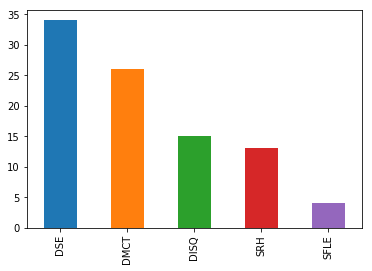

In [15]:
node_depts = list(nx.get_node_attributes(g, 'dept').values())
pd.value_counts(node_depts).plot.bar()
#https://stackoverflow.com/questions/15126679/plot-key-count-per-unique-value-count-in-pandas

Let's visualize the network with each department represented as a different color.


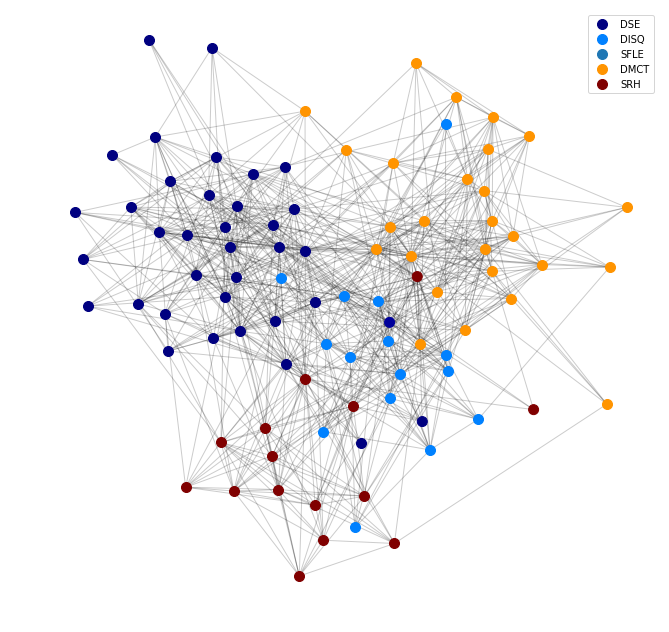

In [16]:
plt.figure(figsize=(11, 11))
depts = set(node_depts) # get unique groups
node_dept_dict = nx.get_node_attributes(g, 'dept')
colors = [plt.cm.jet(x) for x in np.linspace(0, 1, len(depts))]
pos = nx.spring_layout(g)

for i, dept in enumerate(depts):
    dept_nodes = [node for node, value in node_dept_dict.items() if value == dept]
    nx.draw_networkx_nodes(g, pos, nodelist=dept_nodes, node_color=colors[i], label=dept,
                           with_labels=False, node_size=100, cmap=plt.cm.jet)
nx.draw_networkx_edges(g, pos, alpha=0.2)

plt.legend()
plt.axis('off')
plt.show()

# sources: https://stackoverflow.com/questions/28910766/python-networkx-set-node-color-automatically-based-on-number-of-attribute-opt
# https://github.com/MridulS/pydata-networkx/blob/master/game-of-thrones-instructor.ipynb

# Degree Centrality

Look at the number of nodes in this network


In [6]:
len(g)

92

It is not a huge network. 
Degree is returned as a set of name-value pairs, linking node names to the degree value.

Looking at node 95 we see it has 32 degrees. This means it has 32 edge links

In [17]:
deg=nx.degree(g) 
deg[95]

32

Let's find the minimum and maximum number of degrees that exist in our graph for each node by creating a sorted list of all nodes and the degrees

In [18]:
deg_list=list(deg)
deg_list.sort(key=lambda no_edges:no_edges[1])
deg_list[0]
 

(272, 4)

Let's find  the Maximum degrees node

In [19]:
deg_list=list(deg)
deg_list.sort(key=lambda no_edges:no_edges[1])
deg_list[len(deg_list)-1]

(804, 44)

The node with the smallest degree centrality is node 272
while the largest is node 804 with 44 edge limks directly connected to it


We can visualize the subgraph of the smallest degree node 272

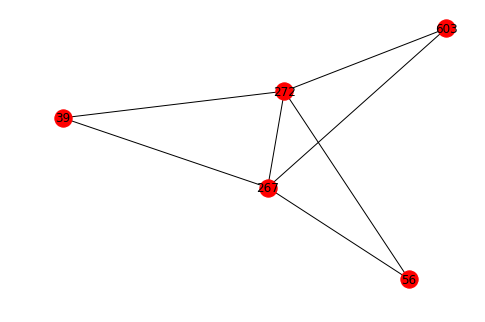

In [20]:
min_deg_node=deg_list[0][0]
list_dn=list(g[min_deg_node])
list_dn.append(min_deg_node)
g_sub=g.subgraph(list_dn)
nx.draw(g_sub, with_labels=True)

Let's visualize the node with the maximum degree of centrality


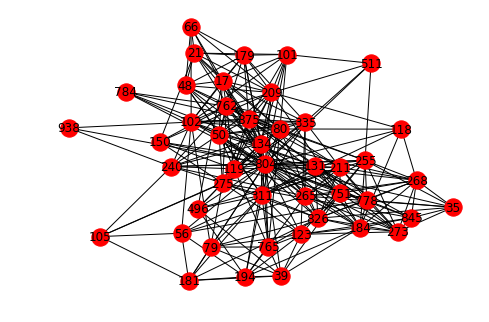

In [21]:
#for the maximum node
max_deg_node=deg_list[len(g)-1][0]
list_dn=list(g[max_deg_node])
list_dn.append(max_deg_node)
g_sub=g.subgraph(list_dn)
nx.draw(g_sub, with_labels=True)

In [22]:
#List top 10 most influential nodes 
deg_list=list(deg)
deg_list.sort(key=lambda no_edges:no_edges[1], reverse=True)
deg_list[0:10]

[(804, 44),
 (311, 38),
 (95, 32),
 (80, 31),
 (134, 30),
 (223, 28),
 (63, 28),
 (826, 26),
 (123, 26),
 (875, 26)]

Let's analyze which department has the highest number of degrees in total


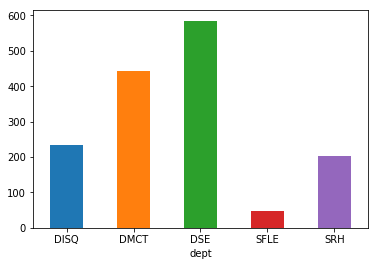

In [23]:
#Get dictionary of all nodes with their degrees
deg_dict=dict(deg_list)
attr_dict
deg_dict
deg_dict.items()
deg_df=pd.DataFrame(deg_list, columns=['node','degree'])
attributes
deg_dept_df=pd.merge(deg_df,
                 attributes,
                 on='node')
deg_dept_df
agg_df=deg_dept_df.groupby(['dept'])['degree'].agg({'summ':'sum'})
agg_df


deg_dept_df.groupby(['dept'])['degree'].agg('sum').plot.bar(x='dept', y='summ', rot=0)
pd.options.mode.chained_assignment = None 

As we can see the DSE department has the highest number of degree centrality

## Closeness Centrality

In closeness centrality we calculate for each node the average shortest path to any node on the network

In [25]:
g_close=nx.closeness_centrality(g)
g_close

g_close_sorted = sorted(g_close.items(), key=lambda kv: kv[1], reverse=True)
g_close_sorted


g_close_sorted_df=pd.DataFrame(g_close_sorted, columns=['node','closeness'])
g_close_sorted_df
g_close_dept_df=pd.merge(g_close_sorted_df,
                 attributes,
                 on='node')
g_close_dept_df
avg_close_df=g_close_dept_df.groupby(['dept'])['closeness'].agg({'Avg':'mean'})


avg_close_df.sort_values(by=['Avg'], ascending=False)


,Avg
dept,
DSE,0.519457
DMCT,0.518303
SFLE,0.513206
DISQ,0.505178
SRH,0.500198


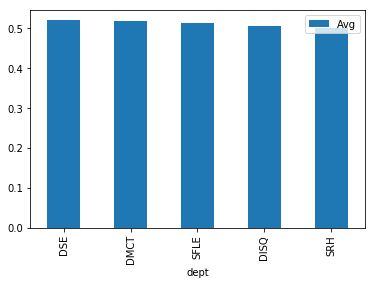

In [33]:
a=avg_close_df.sort_values(by=['Avg'], ascending=False)
a.plot.bar()

Display the top 10 nodes with the highest closeness degree

In [27]:
g_close_sorted[0:10]

[(804, 0.6594202898550725),
 (311, 0.6275862068965518),
 (80, 0.5947712418300654),
 (95, 0.5947712418300654),
 (134, 0.5947712418300654),
 (123, 0.5796178343949044),
 (223, 0.5759493670886076),
 (826, 0.5723270440251572),
 (39, 0.5723270440251572),
 (222, 0.5723270440251572)]

As we can see, node 804 is the node closest to every other node
After taking the average of the closeness of each node, we can see the department that is most close to other depts in the network is DSE

## Betweenness Centrality

Betweenness is a measure of the degree to which nodes serve as bridges or bottlenecks between parts of the network. Nodes with betweenness connect parts of a network that would not otherwise be connected.

Looking at the 10 nodes with the highest betweenness, we see that this network does not have many nodes that serve as bridges and bottlenecks. This would indicate that the company may not be very hierarchical and siloed but more lateral in its connections.

In [284]:
node_betweenness = nx.betweenness_centrality(g)
betw_sorted = sorted(node_betweenness.items(), key=lambda kv: kv[1], reverse=True)
betw_sorted_df = pd.DataFrame(betw_sorted, columns=['node', 'betweenness'])
betw_sorted_df.iloc[0:10,]

,node,betweenness
0,804,0.088996
1,311,0.052649
2,63,0.036704
3,134,0.035499
4,123,0.032542
5,80,0.030053
6,826,0.029332
7,95,0.028764
8,223,0.028762
9,265,0.027588


In the ego graph below, we see that node 804 does have many connections, but that person does not serve as the unique connector between them.

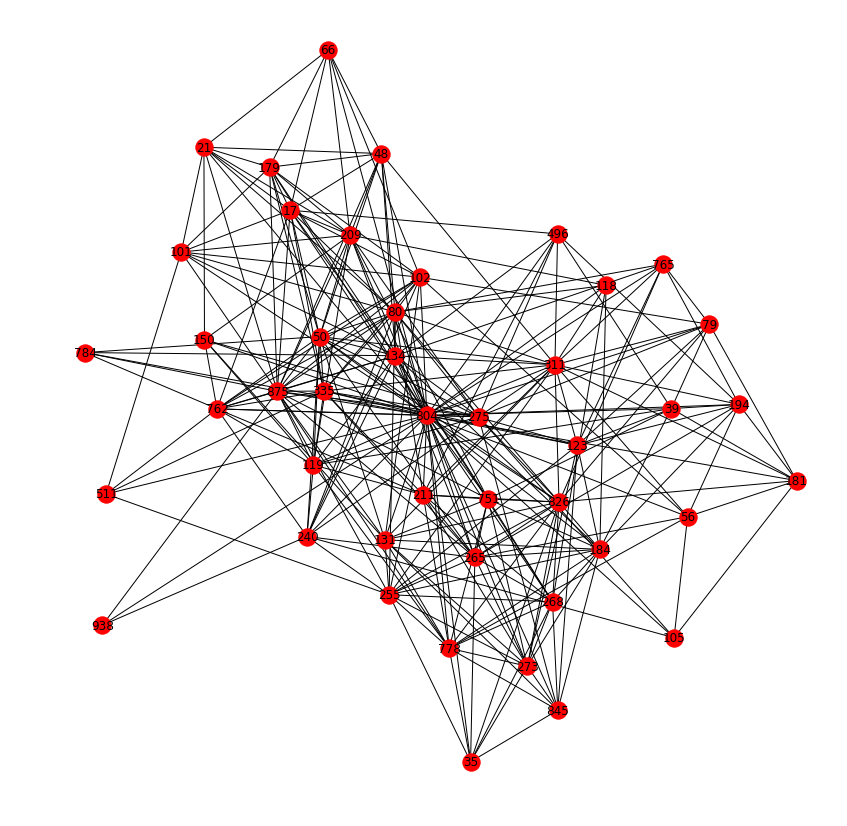

In [255]:
plt.figure(figsize=(11, 11))
g_ego = nx.ego_graph(g, betw_sorted_df.iloc[0, 0])
nx.draw(g_ego, with_labels=True)

On average, we see in the bar plot that the 3rd largest departmetn `DMCT` has slightly more betweenness than the larger `DSE` department.

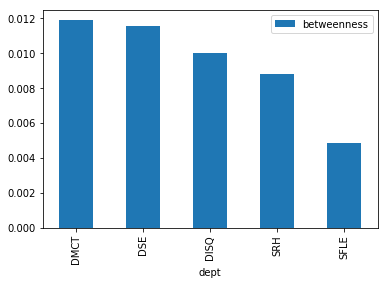

In [277]:
dept_betw_df = pd.merge(betw_sorted_df,
                 attributes,
                 on='node')[['dept', 'betweenness']].groupby('dept').mean().sort_values('betweenness',
                                                                                       ascending = False)
dept_betw_df.plot.bar()

## Eigenvector Centrality

As Tsvetovat & Kouznetsov explain, "eigenvector centrality is like a recursive version of degree centrality." It is a measure of whether a node knows well-connected people.

It's like a weighted version of degree centrality, where the centrality metric for a node is the sum of all of the degrees possessed by the neighbors normalized by the largest value. This process is repeated until the largest value stops changing. 

In the table below, we see that node 804 is also at the top for eigenvector centrality.

In [285]:
node_ev = nx.eigenvector_centrality(g)
ev_sorted = sorted(node_ev.items(), key=lambda kv: kv[1], reverse=True)
ev_sorted_df = pd.DataFrame(ev_sorted, columns=['node', 'ev'])
ev_sorted_df.iloc[0:10,]

,node,ev
0,804,0.234506
1,311,0.228983
2,95,0.188063
3,80,0.184169
4,662,0.171218
5,134,0.170868
6,223,0.163409
7,222,0.162681
8,826,0.152587
9,267,0.149307


The `DSE` department has the highest average eigenvector centrality. It is the largest department, and it had the highest metric in 3 of the 4 centralities we reviewed.

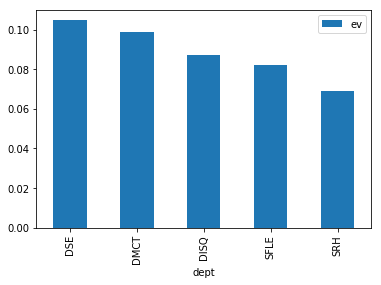

In [289]:
dept_ev_df = pd.merge(ev_sorted_df,
                 attributes,
                 on='node')[['dept', 'ev']].groupby('dept').mean().sort_values('ev',
                                                                               ascending = False)
dept_ev_df.plot.bar()